In [1]:
#@title Use GPU in colab: Runtime->Change Runtime type
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import numpy as np
import math
from sklearn.metrics import mean_squared_error


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [2]:
from load import load_data
train_pd, test_pd = load_data()

# from preprocess import preprocess
# A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, orig_val_ratings, standardized_val_ratings, submission_users, submission_items = preprocess((train_df, submission_df))

# Use provided setup instead
def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)
test_users, test_movies, test_predictions = extract_users_items_predictions(test_pd)

rmse = lambda x, y: math.sqrt(mean_squared_error(x, y))

def get_score(predictions, target_values=test_predictions):
    return rmse(predictions, target_values)

In [3]:
class NCF(nn.Module):
    def __init__(self, number_of_users, number_of_movies, embedding_size):
        super().__init__()
        self.embedding_layer_users = nn.Embedding(number_of_users, embedding_size)
        self.embedding_layer_movies = nn.Embedding(number_of_movies, embedding_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(in_features=2 * embedding_size, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1), # maybe predict per category?
            nn.ReLU()
        )

    def forward(self, users, movies):
        users_embedding = self.embedding_layer_users(users)
        movies_embedding = self.embedding_layer_movies(movies)
        concat = torch.cat([users_embedding, movies_embedding], dim=1)
        return torch.squeeze(self.feed_forward(concat))

In [4]:
# Parameters
batch_size = 1024
num_epochs = 25
show_validation_score_every_epochs = 1
embedding_size = 16
learning_rate = 1e-3

In [5]:
def mse_loss(predictions, target):
    return torch.mean((predictions - target) ** 2)

# Build Dataloaders
train_users_torch = torch.tensor(train_users, device=device)
train_movies_torch = torch.tensor(train_movies, device=device)
train_predictions_torch = torch.tensor(train_predictions, device=device)

train_dataloader = DataLoader(
    TensorDataset(train_users_torch, train_movies_torch, train_predictions_torch),
    batch_size=batch_size)

test_users_torch = torch.tensor(test_users, device=device)
test_movies_torch = torch.tensor(test_movies, device=device)

test_dataloader = DataLoader(
    TensorDataset(test_users_torch, test_movies_torch),
    batch_size=batch_size)

ncf = NCF(10000, 1000, embedding_size).to(device)

optimizer = optim.Adam(ncf.parameters(),
                       lr=learning_rate)

In [6]:
# collect losses for qualitative inspection
ncf_logdir = './tensorboard/ncf'
writer = SummaryWriter(ncf_logdir)

step = 0
with tqdm(total=len(train_dataloader) * num_epochs) as pbar:
    for epoch in range(num_epochs):
        for users_batch, movies_batch, target_predictions_batch in train_dataloader:
            optimizer.zero_grad()

            predictions_batch = ncf(users_batch, movies_batch)

            loss = mse_loss(predictions_batch, target_predictions_batch)

            loss.backward()

            optimizer.step()

            writer.add_scalar('loss', loss, step)
            pbar.update(1)
            step += 1

        if epoch % show_validation_score_every_epochs == 0:

            with torch.no_grad():
                all_predictions = []
                for users_batch, movies_batch in test_dataloader:
                    predictions_batch = ncf(users_batch, movies_batch)
                    all_predictions.append(predictions_batch)

            all_predictions = torch.cat(all_predictions)

            reconstuction_rmse = get_score(all_predictions.cpu().numpy())
            pbar.set_description('At epoch {:3d} loss is {:.4f}'.format(epoch, reconstuction_rmse))

            writer.add_scalar('reconstuction_rmse', reconstuction_rmse, step)

  0%|          | 0/28750 [00:00<?, ?it/s]

In [8]:
final_ratings = all_predictions.cpu().numpy()
print(final_ratings.shape)

(1176952,)


In [9]:
# Clip at 1 and 5

# check min and max of final_ratings_rounded
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# Count the number of values under 1 and over 5
count_under_1 = (final_ratings < 1).sum().item()
count_over_5 = (final_ratings > 5).sum().item()
print("count_over_5:", count_over_5)
print("count_under_1:", count_under_1)

# Clip the values to be within the range [1, 5]
final_ratings = np.clip(final_ratings, 1, 5)

min: 0.9579233527183533
max: 6.364503383636475
mean: 3.639430522918701
count_over_5: 11512
count_under_1: 2


min: 1.0
max: 5.0
mean: 3.637852668762207


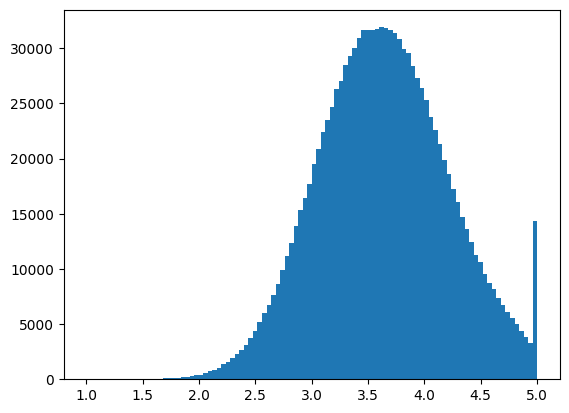

In [11]:
from matplotlib import pyplot as plt
# check min and max of final_ratings
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

In [12]:
# save submission
import pandas as pd
def to_submission_format(users, movies, predictions):
    return pd.DataFrame(data={'Id': ['r{}_c{}'.format(user + 1, movie + 1) for user, movie in zip(users, movies)],
                              'Prediction': predictions})

submission = to_submission_format(test_users, test_movies, final_ratings)

submission.to_csv('../data/submission_data/submission.csv', index=False)